In [14]:
'''

.....IMPORTANT USAGE INSTRUCTIONS........

    IF USING CHPC - UTAH

        Download this Jupyter Notebook to a local location on your Computer

        Go to https://ondemand.chpc.utah.edu and sign in using your uNID and Password.

        At the Top of the Page, notice the Menu "Interactive Apps". Click and Choose "Jupyter Notebook on Notchpeak"

        A form will open, enter all details, and then Launch a Jupyter Notebook. It will take a minute.

        Click on "Connect to Jupyter"

        Once Jupyter Launches. On Top Right Notice "Upload Button". Use this to Upload this Notebook.

        The Notebook will be uploaded. Finish writing the Code whereever specified.

        Run each Block of Code and then finally download the Jupyter Notebook by going to File >> Download as >>


    IF USING GOOGLE COLAB

        Download this Jupyter Notebook to a local location on your Computer

        Go to https://colab.research.google.com/ and sign in using your Google Account - So that your work is saved 
        in your Google Drive permanently.

        Go to File >> Upload Notebook.

        Finish writing the Code whereever specified.

        Run each Block of Code ad then finally download the Jupyter Notebook by going to File >> Download .ipynb

'''

'\n\n.....IMPORTANT USAGE INSTRUCTIONS........\n\n    IF USING CHPC - UTAH\n\n        Download this Jupyter Notebook to a local location on your Computer\n\n        Go to https://ondemand.chpc.utah.edu and sign in using your uNID and Password.\n\n        At the Top of the Page, notice the Menu "Interactive Apps". Click and Choose "Jupyter Notebook on Notchpeak"\n\n        A form will open, enter all details, and then Launch a Jupyter Notebook. It will take a minute.\n\n        Click on "Connect to Jupyter"\n\n        Once Jupyter Launches. On Top Right Notice "Upload Button". Use this to Upload this Notebook.\n\n        The Notebook will be uploaded. Finish writing the Code whereever specified.\n\n        Run each Block of Code and then finally download the Jupyter Notebook by going to File >> Download as >>\n\n\n    IF USING GOOGLE COLAB\n\n        Download this Jupyter Notebook to a local location on your Computer\n\n        Go to https://colab.research.google.com/ and sign in using 

In [15]:
'''
.....IMPORTANT SUBMISSION INSTRUCTIONS........

Once everything runs successfully, download the jupyter notebook and attach that to your submission in Canvas. 
During evaluation, I will run your Jupyter Notebook to verify that everything is running as expected.

Do not forget to include your main results and plots in your latex file (with other homework questions) 
before submission.

'''

'\n.....IMPORTANT SUBMISSION INSTRUCTIONS........\n\nOnce everything runs successfully, download the jupyter notebook and attach that to your submission in Canvas. \nDuring evaluation, I will run your Jupyter Notebook to verify that everything is running as expected.\n\nDo not forget to include your main results and plots in your latex file (with other homework questions) \nbefore submission.\n\n'

In [16]:
%matplotlib inline
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, string
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import skorch
from skorch.helper import predefined_split
from torch.utils.data import ConcatDataset, DataLoader, random_split
from skorch.callbacks import EarlyStopping, Checkpoint

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


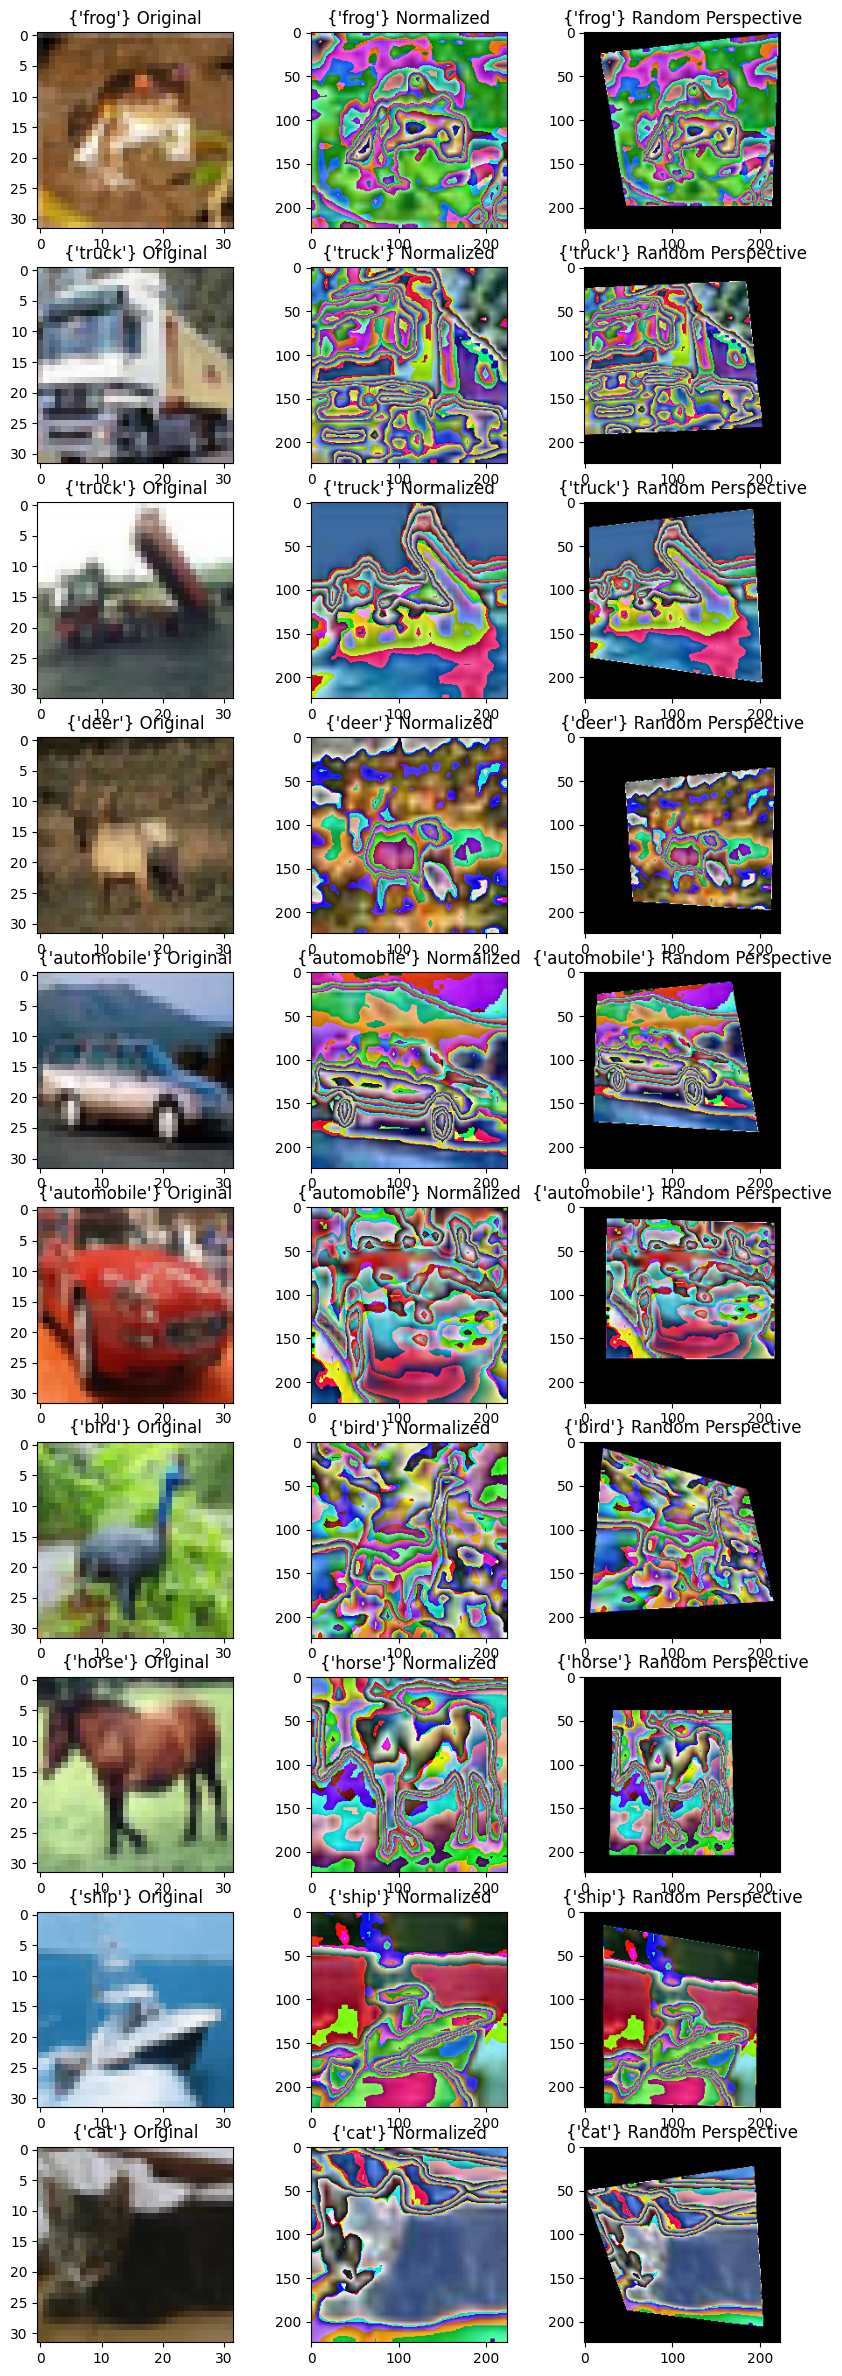

In [17]:
'''
Load the CIFAR10 Dataset

'''
CIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

print(CIFAR10.classes)
targets_dict = CIFAR10.class_to_idx
one_of_each = []
for i, targ in enumerate(CIFAR10.targets):
    if targ not in one_of_each:
        # find the index that is hot
        index = 0
        one_of_each.append((targ, CIFAR10.data[i]))
        if len(one_of_each) == 10:
            break

preprocessN = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

preprocessR = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomPerspective(p=1.0),
])
pill = transforms.ToPILImage()
fig, ax = plt.subplots(10, 3, figsize=(10, 30))
for i, (target, img) in enumerate(one_of_each):
    ax[i, 0].imshow(img)
    target = {i for i in targets_dict if targets_dict[i] == target}
    ax[i,0].set_title(f"{target} Original")
    trans = transforms.ToPILImage()(preprocessN(transforms.ToPILImage()(img)))
    ax[i, 1].imshow(trans)
    ax[i, 1].set_title(f"{target} Normalized")
    trans = transforms.ToPILImage()(preprocessR(transforms.ToPILImage()(img)))
    ax[i, 2].imshow(trans)
    ax[i,2].set_title(f"{target} Random Perspective")
plt.show()



In [18]:

CIFAR10_non_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocessN).dev
CIFAR10_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocessR)
CIFAR10_aug__test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocessN)
CIFAR10_test_non_aug_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocessN)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [19]:

'''
Step - 1 : Download the pretrained ImageNet Model 
'''

resnet = models.resnet18(pretrained=True)
if torch.cuda.is_available():
    resnet.cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

'''
Optional - Print out the structure of Alexnet
'''

print(resnet)
print(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/tim/code/machine_learning/stats6685/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tim/code/machine_learning/stats6685/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The prediction is Tibetan mastiff with probability  0.9875
The prediction with noise is Irish water spaniel with probability  0.1015


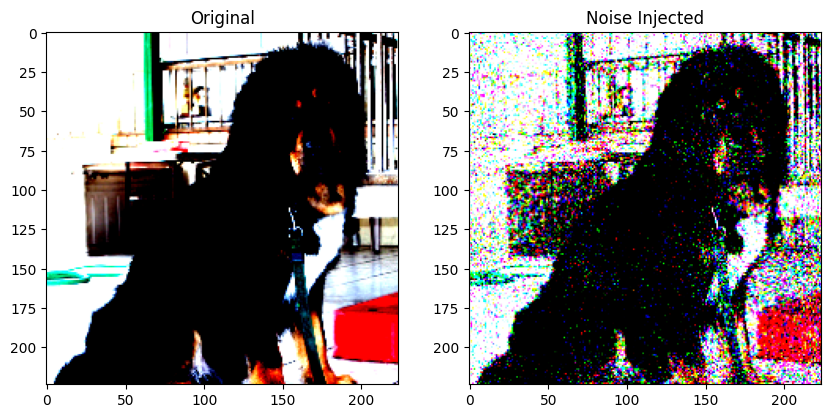

In [20]:

resnet.eval()
'''
Step - 4 : Load a Test Image and Preprocess 
'''
preprocessN = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.unsqueeze(0))  # Add unsqueeze(0) to the transformation
])
IMAGNET = torchvision.datasets.ImageFolder(root='./Test-Images/', transform=preprocessN)
# test resnet on image
test_dogOG = Image.open('./Test-Images/dog/dog.png').convert('RGB')
# transfrom image
inputVarOG = Variable(preprocessN(test_dogOG))
if torch.cuda.is_available():
    inputVarOG = inputVarOG.cuda()
# predict image
predictionOG = resnet(inputVarOG).squeeze(0).softmax(0)
top_probOG = predictionOG.argmax()
labels =  torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]

print(f"The prediction is {labels[top_probOG]} with probability {predictionOG[top_probOG]: .4f}")
# output the top probabilities
class AddNoise(object):
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, image):
        # Convert the image to a PyTorch tensor
        tensor_image = transforms.ToTensor()(image)

        # Generate random noise
        noise = torch.randn_like(tensor_image) * self.noise_level

        # Add the noise to the image
        noisy_image = tensor_image + noise

        # Clip values to [0, 1] range
        noisy_image = torch.clamp(noisy_image, 0, 1)

        # Convert back to PIL Image
        noisy_image = transforms.ToPILImage()(noisy_image)

        return noisy_image

noise = transforms.Compose([
    AddNoise(noise_level=0.3),  # Adjust noise_level as needed
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.unsqueeze(0))  # Add unsqueeze(0) to the transformation
])


# transfrom image
inputVarN = Variable(noise(test_dogOG))
if torch.cuda.is_available():
    inputVarN = inputVarN.cuda()
# predict image
prediction = resnet(inputVarN).squeeze(0).softmax(0)
top_prob = prediction.argmax()


print(f"The prediction with noise is {labels[top_prob]} with probability {prediction[top_prob]: .4f}")
# plot the image and the noisey image
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(inputVarOG.cpu().squeeze(0).permute(1, 2, 0))
ax[0].set_title("Original")
ax[1].imshow(inputVarN.cpu().squeeze(0).permute(1, 2, 0))
ax[1].set_title("Noise Injected")
plt.show()


In [21]:
print(type(CIFAR10_non_aug))
combined = ConcatDataset([CIFAR10_non_aug, CIFAR10_aug])

print(type(combined))

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torch.utils.data.dataset.ConcatDataset'>


In [38]:
import numpy as np
# freeze all layers execpt the last one
resnet.eval()

for name, param in resnet.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False
    else:
        param.requires_grad = True
print(list(resnet.parameters())[0].dtype)  # Print the data type of the weights of the first layer
# define optimizer
# split image net into train and test

#combined_dataset = ConcatDataset([CIFAR10_non_aug, CIFAR10_aug])

net = skorch.NeuralNetClassifier(
    module=resnet,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    callbacks=[('estopper', 
                EarlyStopping(patience=5, 
                            threshold=0.01, 
                            monitor='valid_acc',
                            lower_is_better=False,
                            threshold_mode='abs')),
                ('checkpoint', Checkpoint(monitor='valid_acc_best'))],
    train_split=predefined_split(CIFAR10_aug),
    iterator_train__num_workers = 2,
    iterator_train__pin_memory = True,
    iterator_valid__num_workers = 2,
    iterator_valid__pin_memory = True,
    max_epochs=100,
    device = device,
)
print(CIFAR10_non_aug.data.shape)
input_data = torch.from_numpy(CIFAR10_non_aug.data).to(device)
print(input_data.shape)
target_data = np.array(CIFAR10_non_aug.targets)
target_data = torch.from_numpy(target_data).to(device)
target_data = target_data.float()
input_data = input_data.permute(0, 3, 1, 2)
input_data = input_data.float()
print(input_data.dtype)
print(target_data.dtype)

print(type(CIFAR10_non_aug.data))
net.fit(input_data, y=target_data)


torch.float32
(50000, 32, 32, 3)
torch.Size([50000, 32, 32, 3])
torch.int64
torch.int64
<class 'numpy.ndarray'>


RuntimeError: expected scalar type Long but found Float

In [ ]:

net.module_.eval()
y_true = []
y_pred = []

# Iterate over batches in the test loader
for inputs, targets in test_loader:
    # Forward pass to get predictions
    outputs = net.predict(inputs)
    
    # Append true labels and predicted labels to the lists
    y_true.extend(targets.numpy())
    y_pred.extend(outputs)

# Convert lists to numpy arrays for easier evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)

print(f'Test Accuracy: {accuracy * 100:.2f}%')




In [ ]:
for name, param in resnet.named_parameters():
    if name not in ['fc.weight', 'fc.bias', 'conv1.weight', 'conv1.bias', 'layer1.0.conv1.weight','layer1.0.bn1.weight']:
        param.requires_grad = False
    else:
        param.requires_grad = True
        

net1 = skorch.NeuralNetClassifier(
    module=resnet,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
     callbacks=[('estopper', EarlyStopping(patience=5, 
                                           threshold=0.01, 
                                           monitor='valid_acc',
                                           lower_is_better=False,
                                           threshold_mode='abs')),
                ('checkpoint', Checkpoint(monitor='valid_acc_best'))],
                train_split=predefined_split(CIFAR10_non_aug),
                        iterator_train__num_workers = 2,
                        iterator_train__pin_memory = True,
                        iterator_valid__num_workers = 2,
                        iterator_valid__pin_memory = True,
                        verbose=10,
)

input_data = torch.from_numpy(CIFAR10_non_aug.data).to(device)
target_data = np.array(CIFAR10_non_aug.targets)
target_data = torch.from_numpy(target_data).to(device)

net1.fit(CIFAR10_non_aug, y=None)


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[128, 32, 32, 3] to have 3 channels, but got 32 channels instead

In [ ]:
'''Now visualize the filters
* Look how I am extracting the weights of the 51th filter of the first channel 
and just extend it to create a grid plot of the 64 filters 
'''

plt.imshow(alexnet.features[0].weight.data[50,0,:,:])


In [ ]:
'''Here you will feed to the network your own image. And output the top 5 probabilities of the predicted classes.
* Make sure you make some preprocessing to it, you can also try blurring the image and see what happens
* Make sure your image class corresponds to one of the 1000 classes of alexnet
'''
